In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pickle
import numpy as np
from torch.nn import functional as F

In [2]:
# class FocalLoss(nn.Module):
#     def __init__(self, alpha=1, gamma=2, reduction='mean'):
#         super(FocalLoss, self).__init__()
#         self.alpha = alpha
#         self.gamma = gamma
#         self.reduction = reduction
        
#     def forward(self, inputs, targets):
#         ce_loss = nn.functional.cross_entropy(inputs, targets, reduction='none')
#         pt = torch.exp(-ce_loss)  # Compute the "probability of true" for each class
#         focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss  # Compute Focal Loss
        
#         if self.reduction == 'mean':
#             return focal_loss.mean()
#         elif self.reduction == 'sum':
#             return focal_loss.sum()
#         else:
#             return focal_loss

In [3]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout_prob=None):
        super(MLP, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        
        layers = []
        for i in range(num_layers):
            if i == 0:
                self.fc = nn.Linear(input_dim, hidden_dim)
                nn.init.xavier_uniform_(self.fc.weight)
                layers.append(self.fc)
            else:
                self.fc = nn.Linear(hidden_dim, hidden_dim)
                nn.init.xavier_uniform_(self.fc.weight)
                layers.append(self.fc)
            layers.append(nn.ReLU())
        self.layers = nn.Sequential(*layers)
        
        self.output_layer = nn.Linear(hidden_dim, output_dim)
        nn.init.xavier_uniform_(self.output_layer.weight)
        
    def forward(self, x):
        x = self.layers(x)
        x = self.output_layer(x)
        return x

In [4]:
from torch.utils.data import Dataset, DataLoader
# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        x = torch.tensor(self.data[idx], dtype=torch.float32)
        y = torch.tensor(self.labels[idx], dtype=torch.long)
        return x, y

#### From pre-created train-test set

In [5]:
actions = np.arange(16, 28.5, 0.5)

custom_act_to_orig_act = {idx: action for idx, action in enumerate(actions)}
orig_act_to_custom_act = {action: idx for idx, action in enumerate(actions)}

In [6]:
train_dataset_path = f"../smart-climate/data/smart-climate/smart-climate-train-trajectories-v14-no-filling.pkl"
with open(train_dataset_path, 'rb') as f:
    train_trajectories = pickle.load(f)
    
X_train = np.concatenate([traj['observations'] for traj in train_trajectories])
y_train = np.concatenate([traj['targets'] for traj in train_trajectories])
y_train = np.array([orig_act_to_custom_act[y] for y in y_train])

print(X_train.shape, y_train.shape)

val_dataset_path = f"../smart-climate/data/smart-climate/smart-climate-test-trajectories-v14-no-filling.pkl"
with open(val_dataset_path, 'rb') as f:
    val_trajectories = pickle.load(f)
X_val = np.concatenate([traj['observations'] for traj in val_trajectories])
y_val = np.concatenate([traj['targets'] for traj in val_trajectories])
y_val = np.array([orig_act_to_custom_act[y] for y in y_val])

# X_val = torch.from_numpy(X_val).float()
# y_val = torch.from_numpy(y_val)
print(X_val.shape, y_val.shape)


test_dataset_path = f"../smart-climate/data/smart-climate/smart-climate-test-trajectories-v14-no-filling.pkl"
with open(test_dataset_path, 'rb') as f:
    test_trajectories = pickle.load(f)
X_test = np.concatenate([traj['observations'] for traj in test_trajectories])
y_test = np.concatenate([traj['targets'] for traj in test_trajectories])
y_test = np.array([orig_act_to_custom_act[y] for y in y_test])
print(X_test.shape, y_test.shape)


# Normalize the data
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler()
# scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_val_normalized = scaler.transform(X_val)
X_test_normalized = scaler.transform(X_test)

train_dataset = CustomDataset(X_train_normalized, y_train)
val_dataset = CustomDataset(X_val_normalized, y_val)
test_dataset = CustomDataset(X_test_normalized, y_test)


batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

(19224, 17) (19224,)
(8364, 17) (8364,)
(8364, 17) (8364,)


#### This one is with global pool of data and then creating train-test-val

In [7]:
# train_dataset_path = f"../smart-climate/data/smart-climate/smart-climate-train-trajectories-v14-no-filling.pkl"
# test_dataset_path = f"../smart-climate/data/smart-climate/smart-climate-test-trajectories-v14-no-filling.pkl"
# with open(train_dataset_path, 'rb') as f:
#     train_trajectories = pickle.load(f)
    
# with open(test_dataset_path, 'rb') as f:
#     test_trajectories = pickle.load(f)
    
# trajectories = train_trajectories + test_trajectories

# X = np.concatenate([np.hstack((traj['observations'], traj['rewards'].reshape(-1, 1))) for traj in trajectories])
# y = np.concatenate([traj['targets'] for traj in trajectories])
# y = np.array([orig_act_to_custom_act[y_t] for y_t in y])

# # indices_for_not_16 = [i for i in range(len(y)) if y[i] != 0]
# # X = X[indices_for_not_16]
# # y = y[indices_for_not_16]
# # y = y - 1

# # Split into train, validation, and test sets
# X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
# print(X_train.shape, X_val.shape, X_test.shape)

# # Normalize the data
# from sklearn.preprocessing import StandardScaler, MinMaxScaler
# scaler = StandardScaler()
# # scaler = MinMaxScaler()
# X_train_normalized = scaler.fit_transform(X_train)
# X_val_normalized = scaler.transform(X_val)
# X_test_normalized = scaler.transform(X_test)


# batch_size = 128
# train_dataset = CustomDataset(X_train_normalized, y_train)
# val_dataset = CustomDataset(X_val_normalized, y_val)
# test_dataset = CustomDataset(X_test_normalized, y_test)

# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=batch_size)
# test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [8]:
input_dim = X_train.shape[1]  # Update with the number of input features
hidden_dim = 128  # Adjust the hidden layer size as needed
output_dim = np.unique(y_train).shape[0]  # Update with the number of unique classes
num_layers = 3
dropout_prob = 0.1
alpha = 0.5
gamma = 2
model = MLP(input_dim, hidden_dim, output_dim, num_layers, dropout_prob)
# focal_loss_fn = FocalLoss(alpha=alpha, gamma=gamma)
model

MLP(
  (fc): Linear(in_features=128, out_features=128, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=17, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
  )
  (output_layer): Linear(in_features=128, out_features=25, bias=True)
)

##### Treat it as a regression task

In [9]:
# input_dim = X_train.shape[1]  # Update with the number of input features
# hidden_dim = 128  # Adjust the hidden layer size as needed
# output_dim = 1  # Update with the number of unique classes
# num_layers = 3
# dropout_prob = 0.1
# alpha = 0.5
# gamma = 2
# model = MLP(input_dim, hidden_dim, output_dim, num_layers, dropout_prob)
# # focal_loss_fn = FocalLoss(alpha=alpha, gamma=gamma)
# model

In [10]:
num = 3.8
rounded_num = round(num * 2) / 2
print(rounded_num) 

4.0


In [11]:
# Step 3: Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


# Lists to store loss and accuracy values
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
best_val_loss = float('inf')
patience = 5
counter = 0
# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    total_train_loss, total_train_mse_loss = 0.0, 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        # inputs = (inputs - train_mean) / train_std
        outputs = model(inputs.float())
        _, predicted_train = torch.max(outputs.data, 1)
        # print(outputs.dtype, predicted_val.dtype)
        # print(outputs.shape, predicted_val.shape)
        # print(outputs.dtype, labels.dtype)
        loss = criterion(outputs, labels)
        mse_loss = F.mse_loss(predicted_train.float(), labels.float())
        # loss = focal_loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
        total_train_mse_loss += mse_loss.item()
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

    train_accuracy = correct_train / total_train
    avg_train_loss = total_train_loss / len(train_loader)
    avg_train_mse_loss = total_train_mse_loss / len(train_loader)

    model.eval()
    with torch.no_grad():
        total_val_loss, total_val_mse_loss = 0.0, 0.0
        correct_val = 0
        total_val = 0
        for inputs, labels in val_loader:
            # inputs = (inputs - train_mean) / train_std
            outputs = model(inputs)
            _, predicted_val = torch.max(outputs.data, 1)
            val_loss = criterion(outputs, labels)
            val_mse_loss = F.mse_loss(predicted_val.float(), labels.float())
            # val_loss = focal_loss_fn(outputs, labels)
            total_val_loss += val_loss.item()
            total_val_mse_loss += val_mse_loss.item()
            # print(outputs.data)
            
            total_val += labels.size(0)
            correct_val += (predicted_val == labels).sum().item()

        val_accuracy = correct_val / total_val
        avg_val_loss = total_val_loss / len(val_loader)
        avg_val_mse_loss = total_val_mse_loss / len(val_loader)
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping triggered")
                break

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train MSE Loss: {avg_train_mse_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, 'f'Val Loss: {avg_val_loss:.4f}, Val MSE Loss: {avg_val_mse_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

    # Append values for plotting
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)


Epoch [1/100], Train Loss: 2.7364, Train MSE Loss: 32.9562, Train Accuracy: 0.1543, Val Loss: 2.6163, Val MSE Loss: 30.4736, Val Accuracy: 0.1829
Epoch [2/100], Train Loss: 2.5737, Train MSE Loss: 29.4338, Train Accuracy: 0.1796, Val Loss: 2.5815, Val MSE Loss: 30.6559, Val Accuracy: 0.1772
Epoch [3/100], Train Loss: 2.5469, Train MSE Loss: 30.0222, Train Accuracy: 0.1848, Val Loss: 2.5783, Val MSE Loss: 27.6371, Val Accuracy: 0.1857
Epoch [4/100], Train Loss: 2.5305, Train MSE Loss: 29.0930, Train Accuracy: 0.1845, Val Loss: 2.5564, Val MSE Loss: 30.3867, Val Accuracy: 0.1890
Epoch [5/100], Train Loss: 2.5206, Train MSE Loss: 29.4794, Train Accuracy: 0.1880, Val Loss: 2.5556, Val MSE Loss: 29.1279, Val Accuracy: 0.1797
Epoch [6/100], Train Loss: 2.5109, Train MSE Loss: 29.5904, Train Accuracy: 0.1899, Val Loss: 2.5595, Val MSE Loss: 28.0737, Val Accuracy: 0.1822
Epoch [7/100], Train Loss: 2.5034, Train MSE Loss: 29.4037, Train Accuracy: 0.1937, Val Loss: 2.5551, Val MSE Loss: 30.5247,

#### Test and plot

In [12]:
# Step 5: Evaluate the model on the test data
model.eval()
correct = 0
total = 0
targets = []
preds = []
with torch.no_grad():
    for inputs, labels in test_loader:
        # inputs = (inputs - train_mean) / train_std
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        # print(predicted)
        # print(labels.size(0))
        targets.append(labels)
        preds.append(predicted)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = correct / total
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Accuracy: 0.1883


In [13]:
# actions = np.arange(16.5, 28.5, 0.5)
actions = np.arange(16, 28.5, 0.5)
actions_map = {idx: action for idx, action in enumerate(actions)}

targets = torch.tensor([actions_map[target.item()] for target in torch.cat(targets)])
preds = torch.tensor([actions_map[pred.item()] for pred in torch.cat(preds)])

# if batch size = 1
# targets = torch.tensor([actions_map[target.item()] for target in targets])
# preds = torch.tensor([actions_map[pred.item()] for pred in preds])

In [14]:
# Reward calculation
def calculate_reward(targets, preds):
    errors = abs(targets - preds)
    rewards = (1- (errors / 12)) ** 2
    return sum(rewards) * 100 / len(targets)
rtg = 100
reward = calculate_reward(targets, preds)
print(f"Achieved reward for RTG {rtg}: {reward:.2f}")

Achieved reward for RTG 100: 76.24


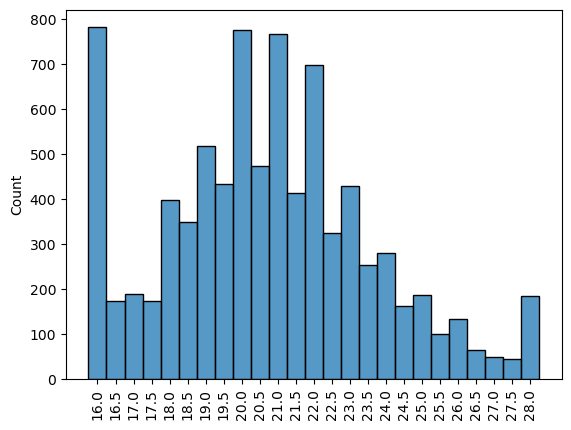

In [15]:
import seaborn as sns
from matplotlib import pyplot as plt
str_targets = sorted([str(target.item()) for target in targets])
sns.histplot(str_targets, bins=49)
plt.xticks(rotation=90)
plt.show()

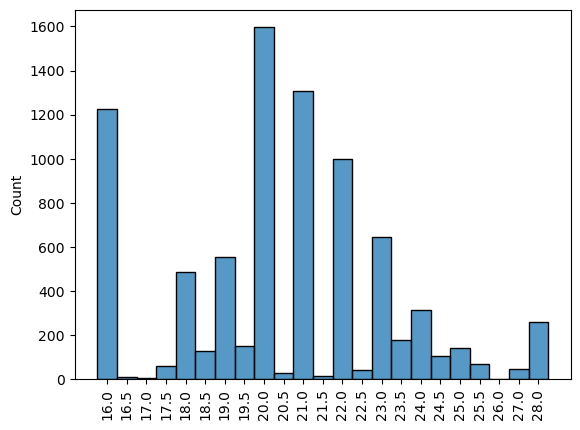

In [16]:
str_preds = sorted([str(pred.item()) for pred in preds])
sns.histplot(str_preds, bins=49)
plt.xticks(rotation=90)
plt.show()

In [17]:
from sklearn.metrics import accuracy_score, classification_report
# Calculate and display the classification report for each class
class_names = sorted(np.unique(str_targets))
report = classification_report(str_targets, str_preds, target_names=class_names)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

        16.0       0.64      1.00      0.78       782
        16.5       0.00      0.00      0.00       173
        17.0       0.00      0.00      0.00       190
        17.5       1.00      0.33      0.50       174
        18.0       0.82      1.00      0.90       398
        18.5       1.00      0.37      0.54       350
        19.0       0.72      0.77      0.75       518
        19.5       0.21      0.07      0.11       434
        20.0       0.49      1.00      0.65       775
        20.5       1.00      0.06      0.11       473
        21.0       0.59      1.00      0.74       766
        21.5       0.00      0.00      0.00       413
        22.0       0.58      0.83      0.69       699
        22.5       0.00      0.00      0.00       326
        23.0       0.46      0.69      0.55       430
        23.5       0.00      0.00      0.00       253
        24.0       0.03      0.03      0.03       281
    

/home/q621464/miniconda3/envs/decision-transformer-gym/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/q621464/miniconda3/envs/decision-transformer-gym/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/q621464/miniconda3/envs/decision-transformer-gym/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

In [18]:
from sklearn.metrics import f1_score
macro_f1 = f1_score(str_targets, str_preds, average='macro')

# Calculate the micro F1 score
micro_f1 = f1_score(str_targets, str_preds, average='micro')

print("Macro F1 Score:", macro_f1)
print("Micro F1 Score:", micro_f1)

Macro F1 Score: 0.30340491042219225
Micro F1 Score: 0.5332376853180296


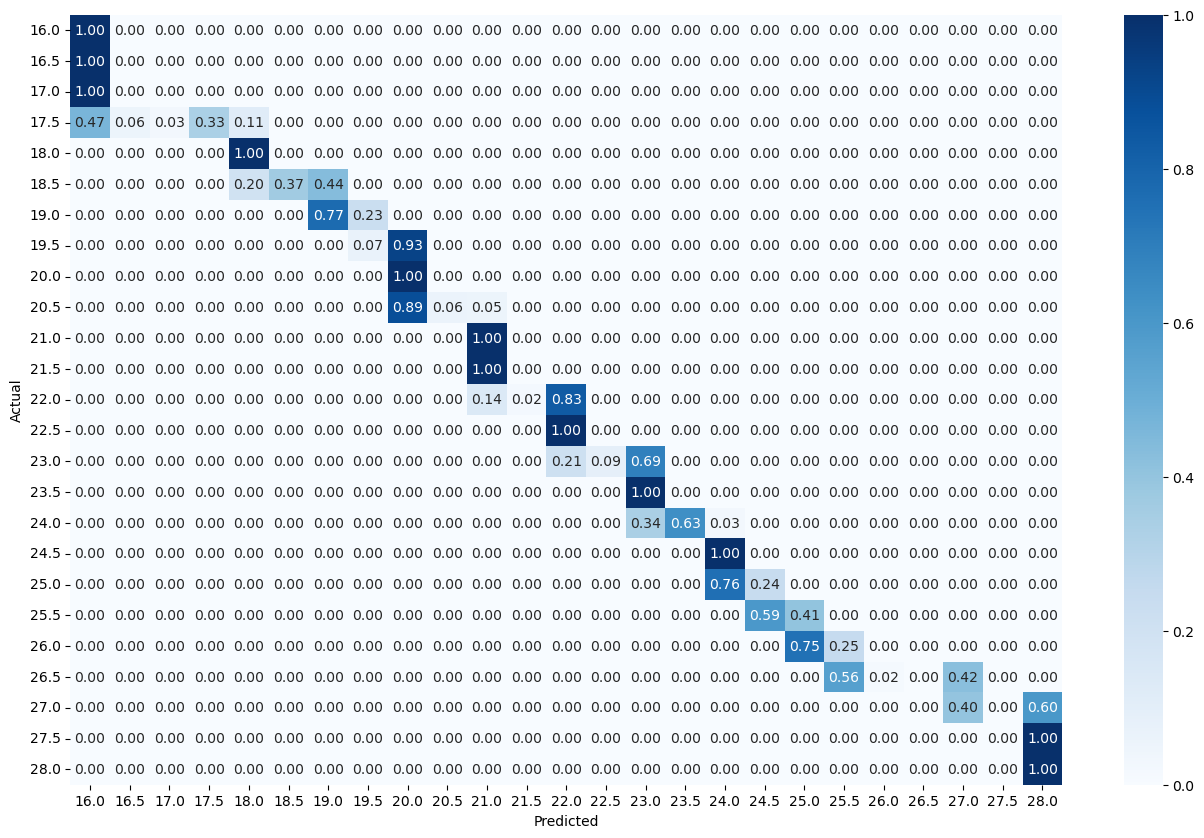

In [19]:
from sklearn.metrics import confusion_matrix
# Build confusion matrix
unique_labels = np.unique(np.concatenate((str_targets, str_preds)))

# Build confusion matrix
cf_matrix = confusion_matrix(str_targets, str_preds, labels=unique_labels)
cf_matrix = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]
# Create a DataFrame from the confusion matrix for better visualization
df_cm = pd.DataFrame(cf_matrix, index=unique_labels, columns=unique_labels)

plt.figure(figsize = (16,10))
# plt.plot(df_cm)
sns.heatmap(df_cm, annot=True, cmap='Blues', cbar=True, fmt=".2f")
plt.xlabel('Predicted')
plt.ylabel('Actual')
# plt.title(f"Confusion matrix for {len(train_dataset)} train and {len(str_preds)} datapoints")
plt.show()
# plt.savefig(f'Figures/Confusion matrix for {len(train_dataset)} train and {len(predicted_actions)} datapoints.jpg')


In [ ]:
import matplotlib.pyplot as plt
# Plot the loss and accuracy curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
train_trajectories[0]['features']

In [21]:
a = np.array([1, 2, 3])
b = np.array([1, 2, 3])
a/b

array([1., 1., 1.])